# Принятие решений в бизнесе

# Проект: Проверка гипотез по увеличению выручки в интернет-магазине — оценка результатов A/B теста

## Описание проекта
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

## Цели и задачи

- Получить данные, проверить их корректность и осуществить предобработку
- Приоретизировать гипотезы по увеличению выручки интернет-магазина
- Проанализировать результаты А/В теста: 
    

    1. Построить графики кумулятивной выручки, среднего чека и конверсии по группам, а также относительного изменения кумулятивного среднего чека и конверсии.
    2. Найти и проанализировать выбросы и аномалии в данных.
    3. Посчитать статистическую значимость различий в конверсии и среднем чеке по "сырым" и "очищенным" данным
    4. Принять решение по результатам А/В-теста

## Описание данных

**Данные для первой части**

Файл /datasets/hypothesis.csv

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


**Данные для второй части**

Файл /datasets/orders.csv

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Подготовка

Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
pd.options.display.max_colwidth = 1

In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
hypothesis.info(), orders.info(), visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

(None, None, None)

In [4]:
hypothesis.describe(), orders.describe(), visitors.describe()

(           Reach     Impact  Confidence    Efforts
 count  9.000000   9.000000   9.000000    9.000000 
 mean   4.777778   4.777778   5.555556    4.888889 
 std    3.153481   3.192874   3.045944    2.803767 
 min    1.000000   1.000000   1.000000    1.000000 
 25%    3.000000   3.000000   3.000000    3.000000 
 50%    3.000000   3.000000   7.000000    5.000000 
 75%    8.000000   7.000000   8.000000    6.000000 
 max    10.000000  10.000000  9.000000    10.000000,
        transactionId     visitorId       revenue
 count  1.197000e+03   1.197000e+03  1.197000e+03
 mean   2.155621e+09   2.165960e+09  8.348006e+03
 std    1.229085e+09   1.236014e+09  3.919113e+04
 min    1.062393e+06   5.114589e+06  5.000000e+01
 25%    1.166776e+09   1.111826e+09  1.220000e+03
 50%    2.145194e+09   2.217985e+09  2.978000e+03
 75%    3.237740e+09   3.177606e+09  8.290000e+03
 max    4.293856e+09   4.283872e+09  1.294500e+06,
          visitors
 count  62.000000 
 mean   607.290323
 std    114.400560
 min

In [5]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [9]:
orders.duplicated().sum(), hypothesis.duplicated().sum(), visitors.duplicated().sum()

(0, 0, 0)

Полученные данные корректны - требовалась лишь замена типа столбцов "date". Приступим к анализу.

In [10]:
orders[['visitorId', 'group']].groupby('visitorId')['visitorId', 'group'].nunique().query('group > 1')

/tmp/ipykernel_348/2802186467.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  orders[['visitorId', 'group']].groupby('visitorId')['visitorId', 'group'].nunique().query('group > 1')


,visitorId,group
visitorId,,
8300375,1,2
199603092,1,2
232979603,1,2
237748145,1,2
276558944,1,2
351125977,1,2
393266494,1,2
457167155,1,2
471551937,1,2


Есть пользователи, которые оказались в нескольких группах одновременно - что делать с этими пользователями пока не ясно, оставим

## Часть 1. Приоритизация гипотез.

Применим фреймворки ICE и RICE, отсортируем их по убыванию приоритета, рассмотрим и изучим получившуюся разницу в приоритетах.

In [11]:
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'], 2)
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [12]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


In [13]:
hypothesis.sort_values('ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


In [14]:
hypothesis.sort_values('RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


**Вывод:**
- Тройка лидеров по ICE: гипотезы 8, 0, 7
- Тройка лидеров по RICE: гипотезы 7, 2, 0

Эта разница объясянется тем, что RICE, в отличие от ICE, включает в себя так же оценку количества пользователей, которых затронет изменение - в гипотезах 7 и 2 она достаточно высока, а в гипотезе 8 - минимальна. В конечном итоге, приорететными будут гипотезы 7, 2 и 0

## Часть 2. Анализ A/B-теста

In [15]:
#достаем уникальные значения дат и групп
datesGroups = orders[['date','group']].drop_duplicates().sort_values(by=['date', 'group'])

#выводим кумулятивные показатели из orders
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(x['date'] >= orders['date'], x['group']==orders['group'])]\
.agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis = 1)
ordersAggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']
#выводим кумулятивные показатели из visitors
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(x['date'] >= visitors['date'], x['group']==visitors['group'])]\
.agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)
#сводим все накопительные данные в одну таблицу
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

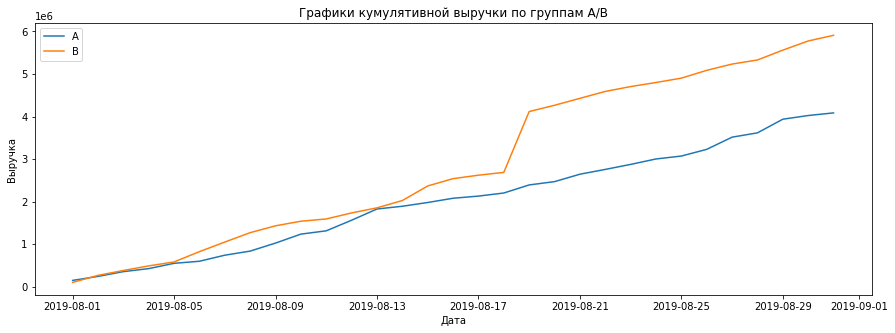

In [16]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.ylabel('Выручка')
plt.xlabel('Дата')

plt.legend() 
plt.show()

В первой половине месяца группа **В** показывает больший рост выручки, чем группа **А**. Во второй половине наблюдается сильный скачок выручки в группе **В** - скорее всего, на это повлияли крупные заказы.

### Построим графики кумулятивного среднего чека по группам 

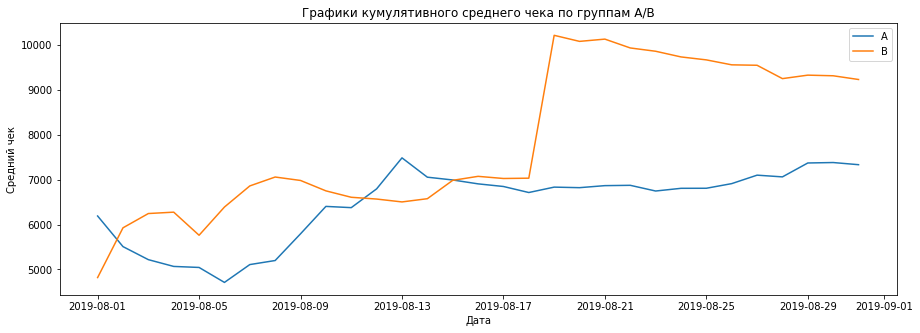

In [17]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()

Средний чек почти всё время выше, но вновь бросается в глаза резкое повышение в середине отслеживаемого периода.

### Построим график относительного различия для среднего чека.

Text(0.5, 0, 'Дата')

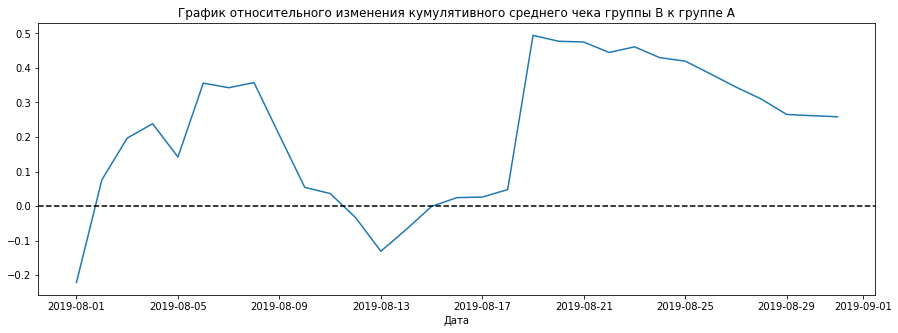

In [18]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')

График различия между сегментами сильно скачет - опять же, нужно будет найти выбросы!

### Построим график кумулятивного среднего количества заказов на посетителя по группам.

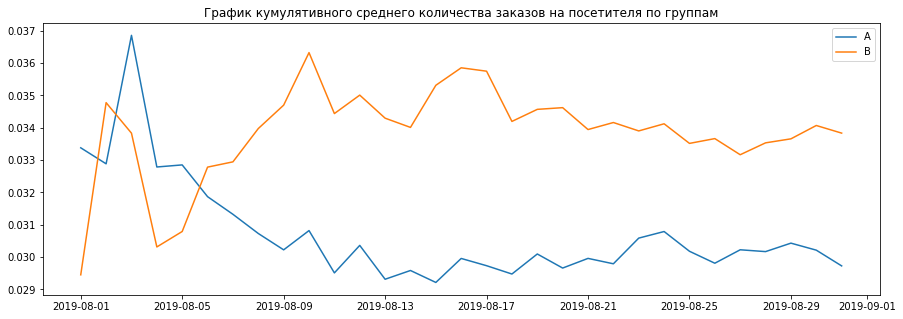

In [19]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(15,5))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.legend()


В начале месяца конверсия группы А была сильно выше, далее конверсия группы А снижалась, а у группы В - наоборот, росла. В общем и целом, мы видим, что с 6 августа конверсия группы В выше конверсии группы А после нестабильного периода в начале месяца.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

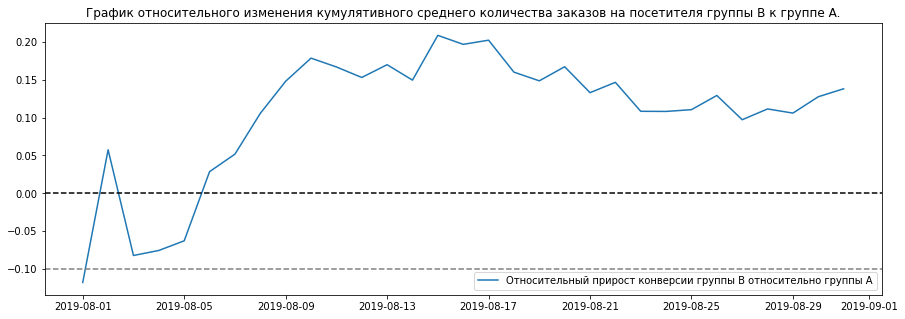

In [20]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] / 
         mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

Этот график дополняет предыдущий - конверсия группы B выше конверсии другой группы на 10% после стабилизации

### Построим точечный график количества заказов по пользователям

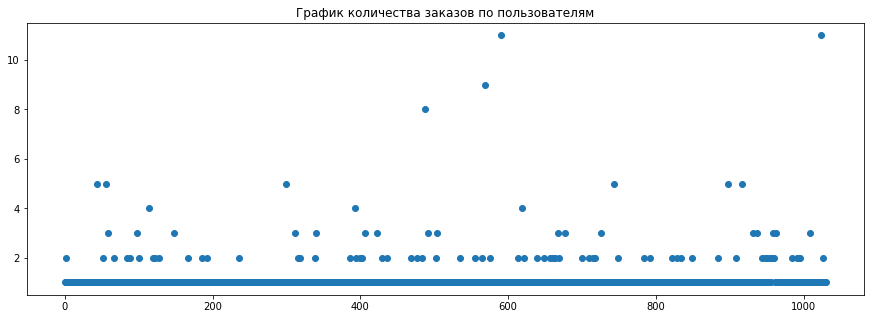

In [21]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['userId','orders']

x_values = range(0, len(ordersByUsers))
plt.figure(figsize=(15, 5))
plt.title('График количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'])

Подавляющее большинство осуществило 1 заказ. Изучим перцентили количества заказов для более точных выводов.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [22]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


95% пользователей совершили не более 2 заказов, а 99% - не более 4 заказов. Думаю, можно считать аномалиями количество заказов большее, чем 2.

### Построим точечный график стоимостей заказов

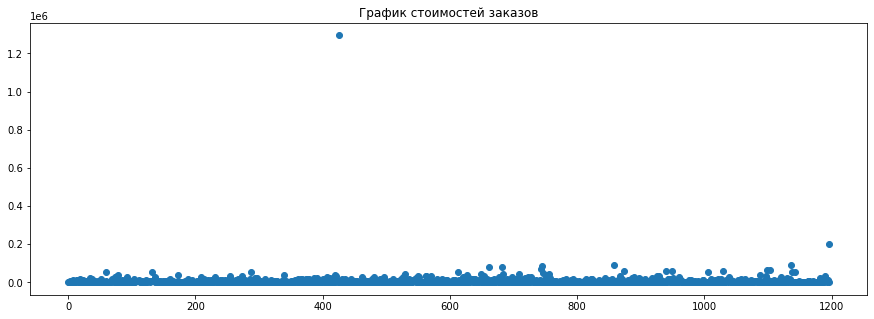

In [23]:
x_values = range(0, len(orders['revenue']))
plt.figure(figsize=(15,5))
plt.title('График стоимостей заказов')
plt.scatter(x_values, orders['revenue']);

Четко виднеются 2 выброса посередине и в конце графика. Построим еще один график без явных выбросов

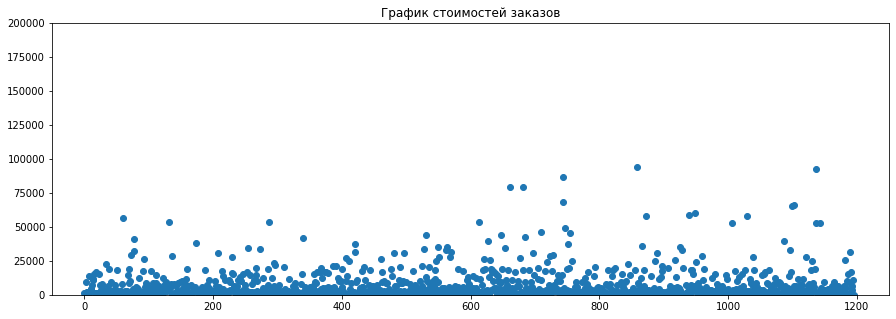

In [24]:
plt.figure(figsize=(15,5))
plt.title('График стоимостей заказов')
plt.axis([-50, 1250, 0, 200000])
plt.scatter(x_values, orders['revenue']);

Видно, что основное скопление - это заказы со стоимостью <20000. Посчитаем перцентили.

### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [25]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


99% заказов имели стоимость не более 58233.2 - возьмем это число за границу для определния аномалий.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Соберем данные по заказам и визитам пользователей в одну таблицу

In [26]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01  24              148579           21               
1 2019-08-02  20              93822            24               
2 2019-08-03  24              112473           16               
3 2019-08-04  16              70825            17               
4 2019-08-05  25              124218           23               

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0  101217           24                  148579                
1  165531           44                  242401                
2  114248           68                  354874                
3  108571           84                  425699                
4  92428            109                 549917                

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0  21                  101217               719                
1  45                  266748               619                
2  61                  380996         

Применим критерий и отформатируем p-value.

Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1

За нулевую гипотезу возьмём, что статистически значимых различий в конверсии между группами нет, тогда альтернативная гипотеза - статистически значимые различия есть.

Примем уровень стат. значимости alpha = 0.05 и критерий Манна-Уитни для проверки.

In [27]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False)\
.agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False)\
.agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum()\
        - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum()\
        - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

alpha = 0.05
p-value = 0.017
Относительный показатель 'B' и 'A' = 0.138


Разница стат. значима - отвергаем нулевую гипотезу, значит, по «сырым» данным различия в конверсиях групп A и B есть. 

Относительный выигрыш группы "B" над "A" равен 13.8% 

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [28]:
print("alpha =", 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                    orders[orders['group']=='B']['revenue'], 
                                                    alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()
                                                            / orders[orders['group']=='A']['revenue'].mean() - 1)) 

alpha = 0.05
p-value = 0.729
Относительный показатель 'B' и 'A' = 0.259


p-value > alpha, мы принимаем нулевую гипотезу - средние чеки по "сырым" данным схожи. 

Средний чек группы B при этом выше, чем у группы А на 26%.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Примем за аномальных пользователей тех, чьё кол-во заказов больше двух и чья сумма заказа больше 58233.2 и очистим данные.

In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(ordersByUsers['orders'], [95]))]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(ordersByUsers['orders'], [95]))]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], [99])) ]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])
print("Всего пользователей =", abnormalUsers.shape[0]) 

1099    148427295
18      199603092
23      237748145
37      249864742
68      457167155
dtype: int64
31
Всего пользователей = 31


In [30]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                                       name='orders')],axis=0) 

print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha = 0.05
p-value = 0.010
Относительный показатель 'B' и 'A' = 0.174


p-value меньше 0.05 - отвергаем гипотезу о том, что статистически значимых различий в конверсии между группами нет. Следовательно, и по «очищенным» данным различия в конверсии групп A и B есть, а относительный выигрыш группы "B" над "A" равен 17,4%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [31]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], alternative = 'two-sided')[1]))

print("Относительный показатель 'B' и 'A' = {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

alpha = 0.05
p-value = 0.798
Относительный показатель 'B' и 'A' = -0.020


p-value больше 0.05 - как и в случае с "сырыми" данными, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако, средний чек группы B оказался незначительно (на 2%) ниже среднего чека группы A, в то время как по "сырым" данным, он был больше на 26%, что объясняется выбросами.

### Примем решение по результатам теста

По результатам тестирования было выявлено:

- Как по "сырым", так и по "очищенным" данным различия в конверсии групп A и B есть, относительный выигрыш группы "B" над "A" равен 17,4% по "очищенным" и 13.8% по "сырым" данным.

- Как по "сырым", так и по "очищенным" данным различия в средних чеках групп A и B отстутствуют, несмотря на то, что средний чек группы B оказался незначительно (на 2%) ниже среднего чека группы A по "очищенным" данным, в то время как по "сырым" данным, он был больше на 26% из-за аномальных заказов.


Считаю, что можно остановить тестирование, признать его успешным и зафиксировать победу группы B - несмотря на небольшую разницу в среднем чеке с группой А, группа В показывает стабильно большую конверсию.

## Вывод

В результате данного проекта мы загрузили и предобработали исходные данные, затем применили различные фреймворки для приоретизации гипотез и выбрали наиболее важные: 7, 2 и 0. 

Кроме того, мы провели анализ результатов A/B теста - построили графики, выявили и исключили аномалии, подготовили выборки и, с помощью критерия Манна-Уитни, проверили гипотезы о равенстве между выборками, и убедились в успешном проведении теста - конверсия группы В увеличилась на 17%, средний чек не изменился.